In [36]:
# supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# load in data
import torch
tensor = torch.load('multivariate_time_matrix.pt')
patients_visits_tensor = torch.load('patients_visits_tensor.pt')

# cuda for gpu training
cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda_available else 'cpu')
torch.backends.cudnn.benchmark = True

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torch.utils.tensorboard import SummaryWriter
# Create a summary writer for logging with Tensorboard
writer = SummaryWriter()

# models
from torch import nn
import numpy as np

In [8]:
# useful global dimension values
tensor_shape = tensor.size()
num_patients = tensor_shape[0]
max_num_visits = tensor_shape[1]
vocab_size = tensor_shape[2]
print(tensor.size())
print(patients_visits_tensor.size())

torch.Size([7537, 42, 856])
torch.Size([7537])


In [9]:
# create features and labels by shifting data, specifically,
# exclude last row vector=visits for features, and exclude first row vector=0 for labels

def construct_input_and_label(tensor, patients_visits_tensor):
    # 7537 (number of patients) x 42 (max number of visits) x 856 (number of unique icd code)
    # how 'useful' visits there are or that are not padded
    dims = patients_visits_tensor - 1
    assert torch.max(dims) == 41
    # maintain same dims as above
    
    X = torch.zeros(num_patients, max_num_visits-1, vocab_size)
    y = torch.zeros(num_patients, max_num_visits-1, vocab_size)
    # which visits are useful and not padding
    mask = torch.zeros(num_patients, max_num_visits-1)
    
    for i in range(num_patients):
        patient_tensor = tensor[i,:,:]
        X[i,:,:] = patient_tensor[:-1,:] # include visits 1-41
        y[i,:,:] = patient_tensor[1:,:] # include visits 2-42
        #print(torch.sum(X[i,:,:]))
        #print(torch.sum(y[i,:,:]))
        mask[i,:dims[i]] = 1
        
    return X, y, mask, dims

In [10]:
X, y, mask, dims = construct_input_and_label(tensor, patients_visits_tensor)
# we need same input size X for RNN

In [22]:
# get X, y with actual examples not padding and broken down by patient
# X is of shape (12455, vocab_size), y is of shape (12455, vocab_size)
stacked_X = torch.zeros(12456, vocab_size)
stacked_y = torch.zeros(12456, vocab_size)
count = 0
for patient in range(num_patients):
    for visit in range(max_num_visits-1):
        # if not padding
        if mask[patient,visit]:
            # make feature vector, same visit bc x,y are aligned now
            stacked_X[count,:] = X[patient,visit,:]
            stacked_y[count,:] = y[patient,visit,:]
            count += 1

In [27]:
print(X.shape)
print(y.shape)
print(stacked_X.shape)
print(stacked_y.shape)
print('There are {} actual visits that are not padding'.format(mask.sum()))

torch.Size([7537, 41, 856])
torch.Size([7537, 41, 856])
torch.Size([12456, 856])
torch.Size([12456, 856])
There are 12456.0 actual visits that are not padding


In [34]:
# calculate important metrics
num_examples = stacked_X.shape[0]
# Label Cardinality (LC) = average number of labels
label_cardinality = stacked_X.sum()/num_examples 
# Label Density = LC divided by number of labels
label_density = label_cardinality/vocab_size
print('Label Cardinality {:.2f}'.format(label_cardinality))
print('Label Density {:.3f}'.format(label_density))

Label Cardinality 11.45
Label Density 0.013


In [54]:
# convert one hot encoding to integer classes
stacked_X_np = stacked_X.numpy()
classes_list = []
label_nums = []
for i in range(num_examples):
    classes_list.extend(np.where(stacked_X_np[i]==1)[0])
    label_nums.append(len(np.where(stacked_X_np[i]==1)[0]))

Text(0, 0.5, 'count')

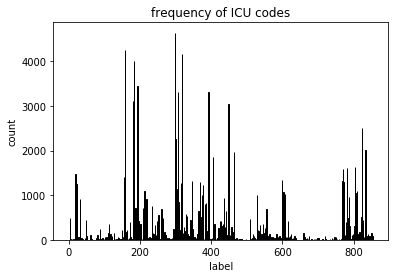

In [61]:
# plot distributions 1. label class distribution 2. number of labels per example distribution
import matplotlib.pyplot as plt
plt.hist(classes_list, color='blue', edgecolor='black', bins=vocab_size)
plt.title('frequency of ICU codes')
plt.xlabel('label')
plt.ylabel('count')

Text(0, 0.5, 'count')

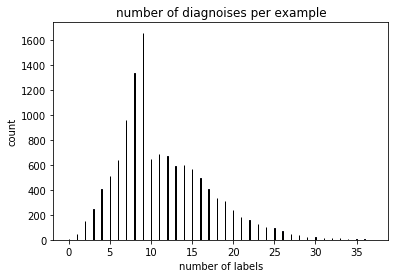

In [62]:
plt.hist(label_nums, color='blue', edgecolor='black', bins=vocab_size)
plt.title('number of diagnoises per example')
plt.xlabel('number of labels')
plt.ylabel('count')

In [64]:
# linear model aX+b trained on entire dataset, model too simple
model = nn.Linear(in_features=vocab_size, out_features=vocab_size)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

for epoch in range(10):
    optimizer.zero_grad()
    output = model(stacked_X)
    loss = criterion(output, stacked_y)
    loss.backward()
    optimizer.step()
    print('Loss: {:.3f}'.format(loss.item()))

Loss: 0.693
Loss: 0.693
Loss: 0.693
Loss: 0.693
Loss: 0.693
Loss: 0.693
Loss: 0.693
Loss: 0.693
Loss: 0.693
Loss: 0.693


In [6]:
# Override Dataset Loader
class icdDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        # the last sample is not used
        return len(self.X)
    def __getitem(self, index):
        # Generate one sample of data from a patient
        return self.X[index], self.y[index]
    
dataset = icdDataset(X, y)
num_samples = X.size()[0]
import math
# 80/20 split
training_set, validation_set = torch.utils.data.random_split(dataset,
    [math.ceil(num_samples*0.8),math.floor(num_samples*0.2)])
    
# Parameters
params = {'batch_size': 5, 
          'shuffle': True,
          'num_workers': 2}
epochs = 20

training_loader = DataLoader(training_set, **params)
validation_loader = DataLoader(validation_set, **params)

In [ ]:
# PCA to map down vocab to lower dimension for classifier
def PCA_analysis(X, y=):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import numpy as np
    X_arr, y_arr = X.numpy(), y.numpy()
    # num_patients*max_num_visits=num of examples
    X_arr = X_arr.reshape(-1, vocab_size) 

    # fit PCA on training set only
    pca = PCA().fit(X_arr)
    feature_list = list(range(vocab_size))
    percent_variance = np.round(pca.explained_variance_ratio_*100, decimals=2)
    
    # graph scree plot
    plt.figure(figsize=(25,10))
    plt.plot(feature_list, percent_variance, marker='x', markersize=10)
    plt.ylabel('Percentage of Variance Explained')
    plt.xlabel('Principal Component')
    plt.title('PCA Scree Plot')
    plt.show()
    
    
#     pca = PCA(n_components=250).fit(X_train)
#     X_train = pca.transform(X_train)
#     X_test = pca.transform(X_test)

In [9]:
training_set

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__():
            self.embedding

SyntaxError: unexpected EOF while parsing (<ipython-input-11-191bbdc6c80d>, line 1)

In [ ]:
import torch.nn
# CNN architecture
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        norm_layer = torch.nn.BatchNorm2d
        
        
    def forward(self,x):
        
        
# LSTM architecture
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel,self).__init__()
    def forward(self,x)

In [ ]:
# training loop


In [ ]:
# TODO:
# alternative: PCA if embedding layer does not work for good representation:

# time series sequence prediction

# time series sequence classifcation

# time series sequence meta-learning, determine disease labels

# include argparse later

# k-fold validation because of small dataset